# Pykep Compatible Problems

The `scocp_pykep` extension provides OCP classes that are made to be compatible with `pykep`'s `planet` module to define initial/final rendez-vous conditions.

> [!NOTE]
> Using the classes defined hereafter requires installing `scocp_pykep` as well as `scocp`. In fact, `scocp_pykep` has `scocp` as one of its dependencies.

We consider a problem where:

- the initial and final conditions are to rendez-vous with planets following Keplerian motion around the central body (a star);
- the initial mass (wet mass) is fixed, and the objective is to maximize the final mass;
- at departure and arrival, a v-infinity vector with a user-defined upper-bound on magnitude may be used;
- the departure time from the initial planet and the arrival time are free and bounded;

This is analogous to [`pykep.trajopt.direct_pl2pl`](https://esa.github.io/pykep/documentation/trajopt.html#pykep.trajopt.direct_pl2pl).

We will start with some imports

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os
import sys

import pykep as pk

sys.path.append("../../..")    # path to scocp & scocp_pykep at the root of the repo
import scocp
import scocp_pykep

We now define our canonical scales.

In [2]:
# define canonical parameters
GM_SUN = pk.MU_SUN           # Sun GM, m^3/s^-2
MSTAR  = 800.0               # reference spacecraft mass
G0     = pk.G0               # gravity at surface, m/s^2

DU = pk.AU                   # length scale set to Sun-Earth distance, m
VU = np.sqrt(GM_SUN / DU)    # velocity scale, m/s
TU = DU / VU                 # time scale, s

We will define the initial and final `pykep.planet` objects (here chosen to be Earth and Mars), the initial departure epoch bounds (defined in MJD), and the arrival time bounds (defined with respect to the initial )

In [3]:
# define initial and final planets
pl0 = pk.planet.jpl_lp('earth')
plf = pk.planet.jpl_lp('mars')

t0_mjd2000_bounds = [1100.0, 1200.0]    # initial epoch in mjd2000
TU2DAY = TU / 86400.0                   # convert non-dimensional time to elapsed time in days

# define transfer problem discretization
tf_bounds = [1200.0, 1700.0]
t0_guess = 0.0
tf_guess = 250.0
N = 30
s_bounds = [0.01*tf_guess, 10*tf_guess]

# max v-infinity vector magnitudes
vinf_dep = 1e3/1e3     # 1000 m/s
vinf_arr = 500/1e3     # 500 m/s


In [ ]:
# spacecraft parameters
ISP    = 3000.0              # specific impulse, s
THRUST = 0.2                 # max thrust, kg.m/s^2

# this is the non-dimentional time integrator for solving the OCP
mu = GM_SUN / (VU**2 * DU)                          # canonical gravitational constant
c1 = THRUST / (MSTAR*DU/TU**2)                      # canonical max thrust
c2 = THRUST/(ISP*G0) / (MSTAR/TU)                   # canonical mass flow rate
print(f"Canonical mu: {mu:1.12e}, c1: {c1:1.4e}, c2: {c2:1.4e}")

ta_dyn, ta_dyn_aug = scocp_pykep.get_heyoka_integrator_twobody_mass(mu, c1, c2, tol=1e-15, verbose=True)
integrator_01domain = scocp_pykep.HeyokaIntegrator(
    nx=8,
    nu=4,
    nv=1,
    ta=ta_dyn,
    ta_stm=ta_dyn_aug,
    impulsive=False
)

Canonical mu: 1.000000000000e+00, c1: 4.2158e-02, c2: 4.2681e-02
Building integrator for state only ... Done! Elapsed time: 0.2509 seconds
Building integrator for state + STM ... 

Building the integrator is a timely procedure - but we can e.g. pickle the `ta_dyn` and `ta_dyn_aug` to speed this up:)

## Construct a fuel-optimal problem

We now construct the optimal control problem class for sequential convex programming corresponding to a rendezvous between two `pykep.planet` objects.

Let $\boldsymbol{x}$ denote the state
$$
\boldsymbol{x}(t) = [x(t),y(t),z(t),v_x(t),v_y(t),v_z(t),m(t)]
$$
and $\boldsymbol{u}$ denote the control 
$$
\boldsymbol{u}(t) = [u_x(t),u_y(t),u_z(t)]
$$
where $\| \boldsymbol{u} \|_2 = \Gamma \in [0,1]$.

The OCP we are solving is
$$
\begin{aligned}
    \min_{\boldsymbol{x},\boldsymbol{u},t_0,t_f}\quad& m(t_f)
    \\ \text{s.t.} \quad&
        \dot{\boldsymbol{x}} = \boldsymbol{f}(\boldsymbol{x}(t), \boldsymbol{u}(t), t)
    \\&
        \begin{bmatrix} \boldsymbol{r}(t_0) \\ \boldsymbol{v}(t_0) \end{bmatrix} =
        \begin{bmatrix} \boldsymbol{r}_{\mathrm{pl0}}(t_0) \\ \boldsymbol{v}_{\mathrm{pl0}}(t_0) \end{bmatrix}
        + \begin{bmatrix} 0_{3\times1} \\ \Delta \boldsymbol{v}_{\infty 0} \end{bmatrix}
    \\& m(t_0) = m_{\mathrm{init}}
    \\&
        \begin{bmatrix} \boldsymbol{r}(t_f) \\ \boldsymbol{v}(t_f) \end{bmatrix} =
        \begin{bmatrix} \boldsymbol{r}_{\mathrm{plf}}(t_f) \\ \boldsymbol{v}_{\mathrm{plf}}(t_f) \end{bmatrix}
        + \begin{bmatrix} 0_{3\times1} \\ \Delta \boldsymbol{v}_{\infty f} \end{bmatrix}
    \\& \| \Delta \boldsymbol{v}_{\infty 0} \|_2 \leq \Delta \boldsymbol{v}_{\infty 0, \max}
    \\& \| \Delta \boldsymbol{v}_{\infty f} \|_2 \leq \Delta \boldsymbol{v}_{\infty f, \max}
\end{aligned}
$$

To solve variable-time optimal control problems, we define $\tau \in [0,1]$ such that the physical time $t$ is a function $t(\tau)$ satisfying $t(0)=t_0$ and $t(1) = t_f$.
We define the augmented state $\tilde{\boldsymbol{x}}$
$$
    \tilde{\boldsymbol{x}}(\tau) = [x(\tau),y(\tau),z(\tau),v_x(\tau),v_y(\tau),v_z(\tau),m(\tau),t(\tau)]^T
$$
and augmented control $\tilde{\boldsymbol{u}}$
$$
    \tilde{\boldsymbol{u}}(\tau) = [u_x(\tau),u_y(\tau),u_z(\tau),s(\tau),\Gamma(\tau)]^T
$$
where $s = \mathrm{d}t/\mathrm{d}\tau$.
The controlled dynamics for the augmented state is given by
$$
    \tilde{\boldsymbol{x}}^{\prime} = \tilde{\boldsymbol{f}}(\tilde{\boldsymbol{x}}(\tau),\tilde{\boldsymbol{u}}(\tau),\tau)
    =
    s \begin{bmatrix}
        \boldsymbol{v}(\tau) \\[0.5em]
        -\dfrac{\mu}{r(\tau)^3} \boldsymbol{r}(\tau) \\
        0 \\
        0
    \end{bmatrix}
    + s \begin{bmatrix}
        \boldsymbol{0}_{3\times1} \\[0.5em]
        \dfrac{c_1}{m(\tau)} \boldsymbol{u}(\tau) \\[0.5em]
        -c_2 \Gamma(\tau) \\[0.5em]
        1
    \end{bmatrix}
    =
    \begin{bmatrix}
        s \boldsymbol{f}(\boldsymbol{x}(\tau),\boldsymbol{u}(\tau),t(\tau)) \\[0.5em]
        s
    \end{bmatrix}
    ,
$$

We formulate the fixed-time OCP in terms of the augmented state

$$
\begin{aligned}
    \min_{\tilde{\boldsymbol{x}}, \tilde{\boldsymbol{u}}} \quad& m(1)
    \\ \text{s.t.} \quad&
        \tilde{\boldsymbol{x}}^{\prime} = \tilde{\boldsymbol{f}}(\tilde{\boldsymbol{x}}(\tau),\tilde{\boldsymbol{u}}(\tau),\tau)
    \\&
        \begin{bmatrix} r(0) \\ v(0) \end{bmatrix} =
        \begin{bmatrix} r_{\mathrm{pl0}}(0) \\ v_{\mathrm{pl0}}(0) \end{bmatrix}
        + \begin{bmatrix} 0_{3\times1} \\ \Delta v_{\infty 0} \end{bmatrix}
    \\& m(0) = m_{\mathrm{init}}
    \\&
        \begin{bmatrix} r(1) \\ v(1) \end{bmatrix} =
        \begin{bmatrix} r_{\mathrm{plf}}(1) \\ v_{\mathrm{plf}}(1) \end{bmatrix}
        + \begin{bmatrix} 0_{3\times1} \\ \Delta v_{\infty f} \end{bmatrix}
    \\& \| \Delta v_{\infty 0} \|_2 \leq \Delta v_{\infty 0, \max}
    \\& \| \Delta v_{\infty f} \|_2 \leq \Delta v_{\infty f, \max}
\end{aligned}
$$

Note: in the code, we denote $\Gamma$ with `v`.

In [5]:
# create problem
problem = scocp_pykep.scocp_pl2pl(
    integrator_01domain,
    pl0,
    plf,
    MSTAR,
    pk.MU_SUN,
    N,
    t0_mjd2000_bounds,
    tf_bounds,
    s_bounds,
    vinf_dep,
    vinf_arr,
    r_scaling = pk.AU,
    v_scaling = pk.EARTH_VELOCITY,
    uniform_dilation = True,
    objective_type = "mf",
)

The SCv* star algorithm needs an initial guess, which doesn't need to be feasible.
The `scocp_pl2pl` class provides a method for generating one by linearly interpolating between the initial and final orbital elements. Note that we could use any other way to generate some initial guess - and the "better" the initial guess is, the faster SCvx* will converge to a (hopefully better) local minimum - but of course that's not trivial:)

In [6]:
# create initial guess
xbar, ubar, vbar = problem.get_initial_guess(t0_guess, tf_guess)
geq_nl_ig, sols_ig = problem.evaluate_nonlinear_dynamics(xbar, ubar, vbar, steps=5)   # evaluate initial guess
print(f"Max dynamics constraint violation: {np.max(np.abs(geq_nl_ig)):1.4e}")

Max dynamics constraint violation: 8.2874e-02


Let's see what our initial guess trajectory looks like:

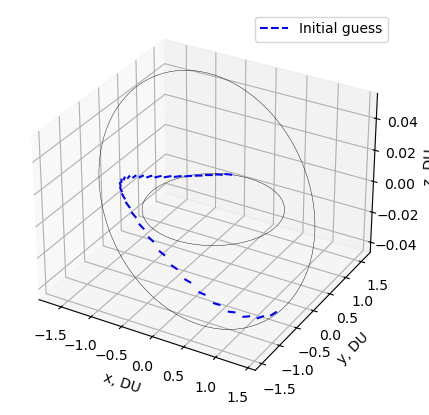

In [ ]:
# initial and final orbits
initial_orbit_states = problem.get_initial_orbit()
final_orbit_states = problem.get_final_orbit()

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1,projection='3d')
ax.set(xlabel="x, DU", ylabel="y, DU", zlabel="z, DU")
ax.plot(initial_orbit_states[1][:,0], initial_orbit_states[1][:,1], initial_orbit_states[1][:,2], 'k-', lw=0.3)
ax.plot(final_orbit_states[1][:,0], final_orbit_states[1][:,1], final_orbit_states[1][:,2], 'k-', lw=0.3)
for idx,(_ts, _ys) in enumerate(sols_ig):
    if idx == 0:
        label = "Initial guess"
    else:
        label = None
    ax.plot(_ys[:,0], _ys[:,1], _ys[:,2], '--', color='b', label=label)
ax.legend()
plt.show()


## Solve fuel-optimal problem

We can now solve the problem! 
We construct an instance of the SCvx* algorithm (`scocp.SCvxStar`), then call `algo.solve()`.
Make sure that the feasibility tolerance (here set to `tol_feas = 1e-12`) is bigger than the integrator's tolerance (using heyoka, we had set it to `1e-15`).

In [ ]:
# setup algorithm & solve
tol_feas = 1e-12
tol_opt = 1e-6
algo = scocp.SCvxStar(problem, tol_opt=tol_opt, tol_feas=tol_feas, rho1=1e-8, r_bounds=[1e-10, 10.0])
solution = algo.solve(
    xbar,
    ubar,
    vbar,
    maxiter = 200,
    verbose = True
)
xopt, uopt, vopt, yopt, sols, summary_dict = solution.x, solution.u, solution.v, solution.y, solution.sols, solution.summary_dict
assert summary_dict["status"] == "Optimal"
assert summary_dict["chi"][-1] <= tol_feas



|  Iter  |     J0      |   Delta J   |   Delta L   |    chi     |     rho     |     r      |   weight   | step acpt. |
     1   | -6.0000e-01 |  5.6141e+00 |  5.5231e+00 | 2.7659e-02 |  1.0165e+00 | 1.0000e-01 | 1.0000e+02 |    yes     |
     2   | -9.0000e-01 |  4.8278e+00 |  5.1550e+00 | 2.6453e-02 |  9.3653e-01 | 3.0000e-01 | 2.0000e+02 |    yes     |
     3   | -9.0118e-01 | -2.3501e+01 |  4.0735e+00 | 1.9554e-01 | -5.7693e+00 | 9.0000e-01 | 4.0000e+02 |    no      |
     4   | -9.0970e-01 | -1.5692e+00 |  3.6245e+00 | 6.1852e-02 | -4.3294e-01 | 4.5000e-01 | 4.0000e+02 |    no      |
     5   | -8.9604e-01 |  2.6033e+00 |  3.2212e+00 | 2.9011e-02 |  8.0819e-01 | 2.2500e-01 | 4.0000e+02 |    yes     |
     6   | -7.8675e-01 | -5.4710e+00 |  6.0095e+00 | 1.0895e-01 | -9.1040e-01 | 6.7500e-01 | 8.0000e+02 |    no      |
     7   | -7.9593e-01 |  4.4637e+00 |  5.4022e+00 | 2.0046e-02 |  8.2628e-01 | 3.3750e-01 | 8.0000e+02 |    yes     |
     8   | -7.6107e-01 | -8.8498e+01 |  4.9114e

In [9]:
problem.pretty(solution)


 ********* Trajectory summary ********* 
   Objective type       : mf
   Departure            : 1106.7260 MJD
   Arrival              : 1474.0186 MJD
   TOF                  : 374.0186 days
   Final mass           : 673.1546 kg
   Departure v-infinity : 1000.00 m/s
   Arrival v-infinity   : 500.00 m/s




In [10]:
# evaluate nonlinear violations
geq_nl_opt, sols = problem.evaluate_nonlinear_dynamics(xopt, uopt, vopt, steps=4)
print(f"Max dynamics constraint violation: {np.max(np.abs(geq_nl_opt)):1.4e}")
assert np.max(np.abs(geq_nl_opt)) <= tol_feas

Max dynamics constraint violation: 2.0750e-13


In [60]:
# extract solution
ts_mjd2000, states, controls = problem.process_solution(solution)
print(f"ts_mjd2000.shape = {ts_mjd2000.shape}")
print(f"states.shape = {states.shape}")
print(f"controls.shape = {controls.shape}")

ts_mjd2000.shape = (31,)
states.shape = (31, 7)
controls.shape = (30, 3)


In the above,
- `ts_mjd2000` is a 1D array of the time-stamps of the `N+1` nodes in MJD,
- `controls` is a 2D array containing the thrust throttles in each row for the `N` control segments (remember we solved this via a stark model, i.e. constant thrust is applied across the segment), and
- `states` is a 2D array containing the cartesian state and mass of the spacecraft at the beginning of each node.

### Plot results

Let's plot the results! Let's first look at our controlled trajectory:

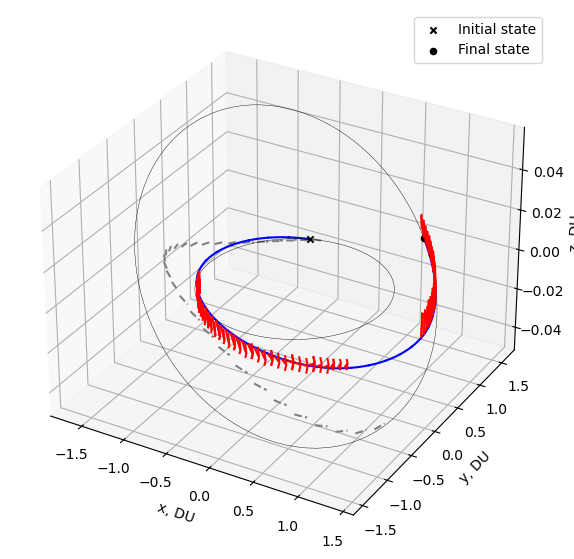

In [71]:
# plot trajectory
x0 = problem.target_initial.target_state(xopt[0,7])
xf = problem.target_final.target_state(xopt[-1,7])

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(1,1,1,projection='3d')
ax.set(xlabel="x", ylabel="y", zlabel="z")
for (_ts, _ys) in sols_ig:
    ax.plot(_ys[:,0], _ys[:,1], _ys[:,2], '--', color='grey')
for (_ts, _ys) in sols:
    ax.plot(_ys[:,0], _ys[:,1], _ys[:,2], 'b-')
    _us_zoh = scocp.zoh_controls(problem.times, uopt, _ts)
    ax.quiver(_ys[:,0], _ys[:,1], _ys[:,2], _us_zoh[:,0], _us_zoh[:,1], _us_zoh[:,2], color='r', length=0.05)

ax.scatter(x0[0], x0[1], x0[2], marker='x', color='k', label='Initial state')
ax.scatter(xf[0], xf[1], xf[2], marker='o', color='k', label='Final state')
ax.plot(initial_orbit_states[1][:,0], initial_orbit_states[1][:,1], initial_orbit_states[1][:,2], 'k-', lw=0.3)
ax.plot(final_orbit_states[1][:,0], final_orbit_states[1][:,1], final_orbit_states[1][:,2], 'k-', lw=0.3)
# ax.set_aspect('equal')
ax.set(xlabel="x, DU", ylabel="y, DU", zlabel="z, DU")
ax.legend()
plt.show()

Let's also look at the mass history and the control history:

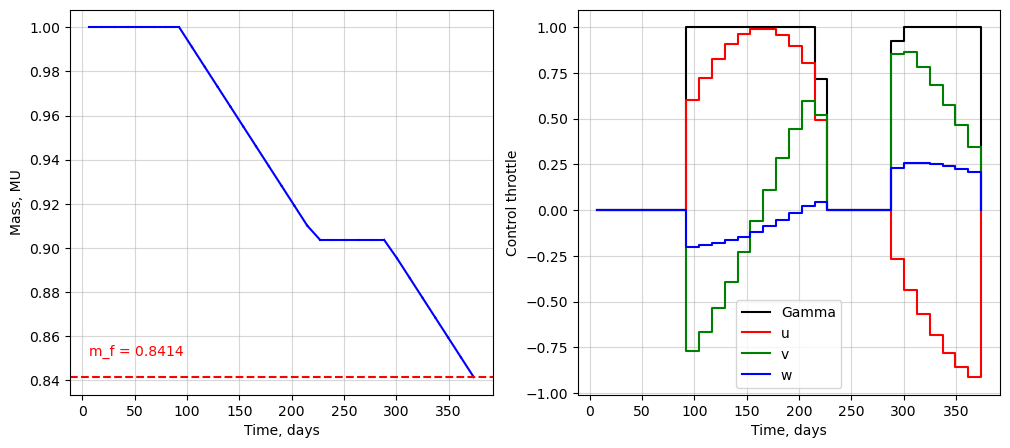

In [ ]:
fig = plt.figure(figsize=(12,5))
ax_m = fig.add_subplot(1,2,1)
ax_m.grid(True, alpha=0.5)
for (_ts, _ys) in sols:
    ax_m.plot(_ys[:,7]*problem.TU2DAY, _ys[:,6], 'b-')
ax_m.axhline(sols[-1][1][-1,6], color='r', linestyle='--')
ax_m.text(xopt[0,7]*problem.TU2DAY, 0.01 + sols[-1][1][-1,6], f"m_f = {sols[-1][1][-1,6]:1.4f}", color='r')
ax_m.set(xlabel="Time, days", ylabel="Mass, MU")
#ax_m.legend()

ax_u = fig.add_subplot(1,2,2)
ax_u.grid(True, alpha=0.5)
ax_u.step(xopt[:,7]*problem.TU2DAY, np.concatenate((vopt[:,0], [0.0])), label="Gamma", where='post', color='k')
ax_u.step(xopt[:,7]*problem.TU2DAY, np.concatenate((uopt[:,0], [0.0])), label="u", where='post', color='r')
ax_u.step(xopt[:,7]*problem.TU2DAY, np.concatenate((uopt[:,1], [0.0])), label="v", where='post', color='g')
ax_u.step(xopt[:,7]*problem.TU2DAY, np.concatenate((uopt[:,2], [0.0])), label="w", where='post', color='b')
ax_u.set(xlabel="Time, days", ylabel="Control throttle")
ax_u.legend()
plt.show()

Let's also see the convergence of the SCVx* algorithm - we will look at the iterates of $|\Delta J|$, i.e. the actual cost reduction in a single SCP step,  and $\chi$, i.e. max nonlinear constraint violation at a given SCP step:

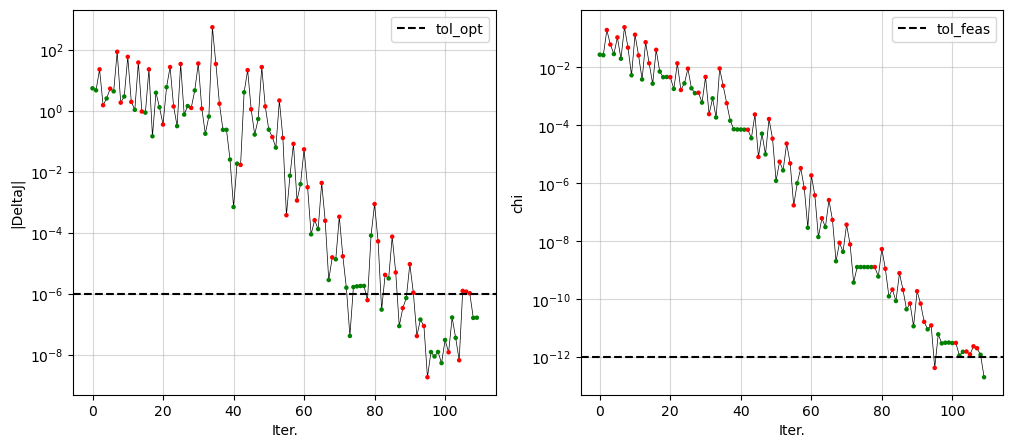

In [ ]:
fig = plt.figure(figsize=(12,5))
ax_DeltaJ = fig.add_subplot(1,2,1)
ax_DeltaJ.grid(True, alpha=0.5)
algo.plot_DeltaJ(ax_DeltaJ, summary_dict)
ax_DeltaJ.axhline(tol_opt, color='k', linestyle='--', label='tol_opt')
ax_DeltaJ.legend()

ax_DeltaL = fig.add_subplot(1,2,2)
ax_DeltaL.grid(True, alpha=0.5)
algo.plot_chi(ax_DeltaL, summary_dict)
ax_DeltaL.axhline(tol_feas, color='k', linestyle='--', label='tol_feas')
ax_DeltaL.legend()
plt.show()

## Verify the solution

Let us now check if our constructed trajectory is dynamically feasible via forward single-shot propagation (remember: the dynamics was enforced in a multiple-shooting sence within the OCP).
For this, we make use of `pykep.propagate_taylor` (from pykep 2.X) or `pykep.stark_problem` (from pykep 3.X).

In [16]:
r,v,m = pk.propagate_taylor(r0 = [1,0,0],
                         v0 = [0,1,0],
                         m0 = 100,
                         thrust = [0,0,0],
                         tof = np.pi/2,
                         mu = 1,
                         veff = 1,
                         log10tol =-15,
                         log10rtol = -15)

In [ ]:
ts_mjd2000, states, controls = problem.process_solution(solution)

In [118]:
x0_iter = copy.deepcopy(xopt[0,0:7])     # initial spacecraft state
states_singleshoot = [x0_iter,]

for idx, (t0,u0) in tqdm(enumerate(zip(ts_mjd2000, controls)), total=len(controls)):
    r,v,m = pk.propagate_taylor(
        r0 = x0_iter[0:3],
        v0 = x0_iter[3:6],
        m0 = x0_iter[6],
        thrust = c1 * np.array(u0),
        tof = xopt[idx+1,7] - xopt[idx,7],
        mu = mu,
        veff = c1/c2,
        log10tol =-15,
        log10rtol = -15)
    
    # update spacecraft state
    x0_iter = np.concatenate((r,v,[m]))

    states_singleshoot.append(copy.deepcopy(x0_iter))
states_singleshoot = np.array(states_singleshoot)

  0%|          | 0/30 [00:00<?, ?it/s]

In [119]:
states_singleshoot[-1,:] - xopt[-1,0:7]   # offset of final state

array([-9.52554258e-10, -3.00509617e-10, -3.52224231e-11, -4.18381330e-10,
       -5.96696192e-10, -6.69477772e-11,  3.94931232e-09])

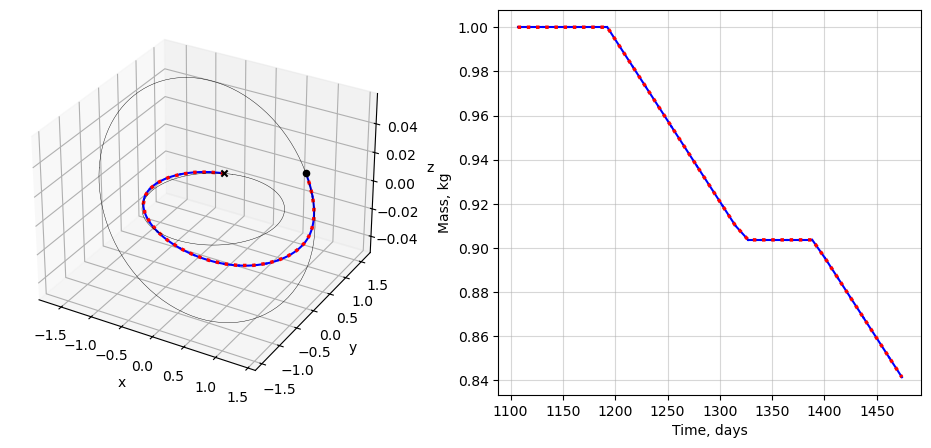

In [ ]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1,projection='3d')
ax.set(xlabel="x", ylabel="y", zlabel="z")
for (_ts, _ys) in sols:
    ax.plot(_ys[:,0], _ys[:,1], _ys[:,2], 'b-', linewidth=1.5)
ax.plot(states_singleshoot[:,0], states_singleshoot[:,1], states_singleshoot[:,2], 'r:', linewidth=2.5)
ax.scatter(x0[0], x0[1], x0[2], marker='x', color='k', label='Initial state')
ax.scatter(xf[0], xf[1], xf[2], marker='o', color='k', label='Final state')
ax.plot(initial_orbit_states[1][:,0], initial_orbit_states[1][:,1], initial_orbit_states[1][:,2], 'k-', lw=0.3)
ax.plot(final_orbit_states[1][:,0], final_orbit_states[1][:,1], final_orbit_states[1][:,2], 'k-', lw=0.3)

axm = fig.add_subplot(1,2,2)
axm.grid(True, alpha=0.5)
axm.set(xlabel="Time, days", ylabel="Mass, kg")
for (_ts, _ys) in sols:
    axm.plot(problem.t0_min + _ys[:,7]*problem.TU2DAY, _ys[:,6], 'b-', linewidth=1.5)
axm.plot(ts_mjd2000, states_singleshoot[:,6], 'r:', linewidth=2.5)
plt.show()


Let's also try propagating in SI units

In [126]:
x0_iter[6]

2047.7800700865148

In [122]:
x0_iter = states[0,0:7]     # initial spacecraft state

states_singleshoot = [x0_iter,]

for idx, (t0,u0) in tqdm(enumerate(zip(ts_mjd2000, controls)), total=len(controls)):
    r,v,m = pk.propagate_taylor(
        r0 = x0_iter[0:3],
        v0 = x0_iter[3:6],
        m0 = x0_iter[6],
        thrust = THRUST * np.array(u0),
        tof = (ts_mjd2000[idx+1] - ts_mjd2000[idx])*86400,
        mu = pk.MU_SUN,
        veff = ISP*G0,
        log10tol =-15,
        log10rtol = -15)
    
    # update spacecraft state
    x0_iter = np.concatenate((r,v,[m]))

    states_singleshoot.append(copy.deepcopy(x0_iter))
states_singleshoot = np.array(states_singleshoot)

  0%|          | 0/30 [00:00<?, ?it/s]

In [123]:
xopt[0,0:3]*problem.r_scaling, solution.x[0,0:3]*problem.r_scaling

(array([-5.28130745e+10,  1.37316537e+11, -9.76442205e+05]),
 array([-5.28130745e+10,  1.37316537e+11, -9.76442205e+05]))

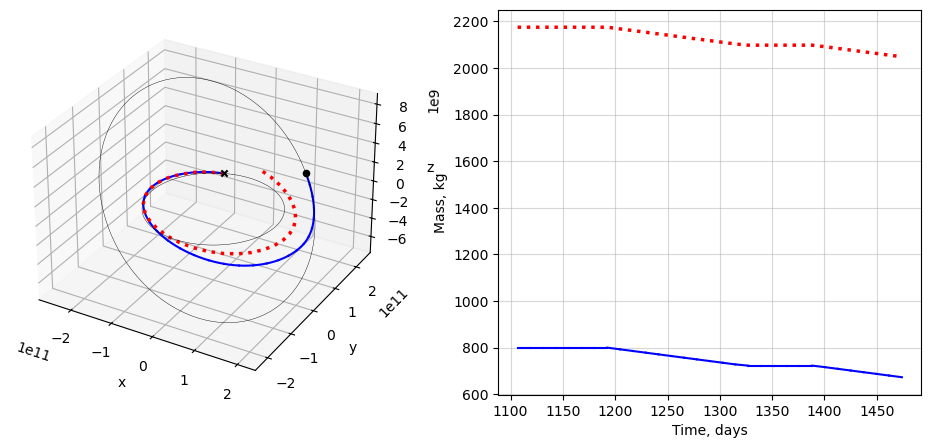

In [ ]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1,projection='3d')
ax.set(xlabel="x", ylabel="y", zlabel="z")
for (_ts, _ys) in sols:
    ax.plot(_ys[:,0]*DU, _ys[:,1]*DU, _ys[:,2]*DU, 'b-', linewidth=1.5)
ax.plot(states_singleshoot[:,0], states_singleshoot[:,1], states_singleshoot[:,2], 'r:', linewidth=2.5)
ax.scatter(x0[0]*DU, x0[1]*DU, x0[2]*DU, marker='x', color='k', label='Initial state')
ax.scatter(xf[0]*DU, xf[1]*DU, xf[2]*DU, marker='o', color='k', label='Final state')
ax.plot(initial_orbit_states[1][:,0]*DU, initial_orbit_states[1][:,1]*DU, initial_orbit_states[1][:,2]*DU, 'k-', lw=0.3)
ax.plot(final_orbit_states[1][:,0]*DU, final_orbit_states[1][:,1]*DU, final_orbit_states[1][:,2]*DU, 'k-', lw=0.3)


axm = fig.add_subplot(1,2,2)
axm.grid(True, alpha=0.5)
axm.set(xlabel="Time, days", ylabel="Mass, kg")
for (_ts, _ys) in sols:
    axm.plot(problem.t0_min + _ys[:,7]*problem.TU2DAY, _ys[:,6]*MSTAR, 'b-', linewidth=1.5)
axm.plot(ts_mjd2000, states_singleshoot[:,6], 'r:', linewidth=2.5)
plt.show()
